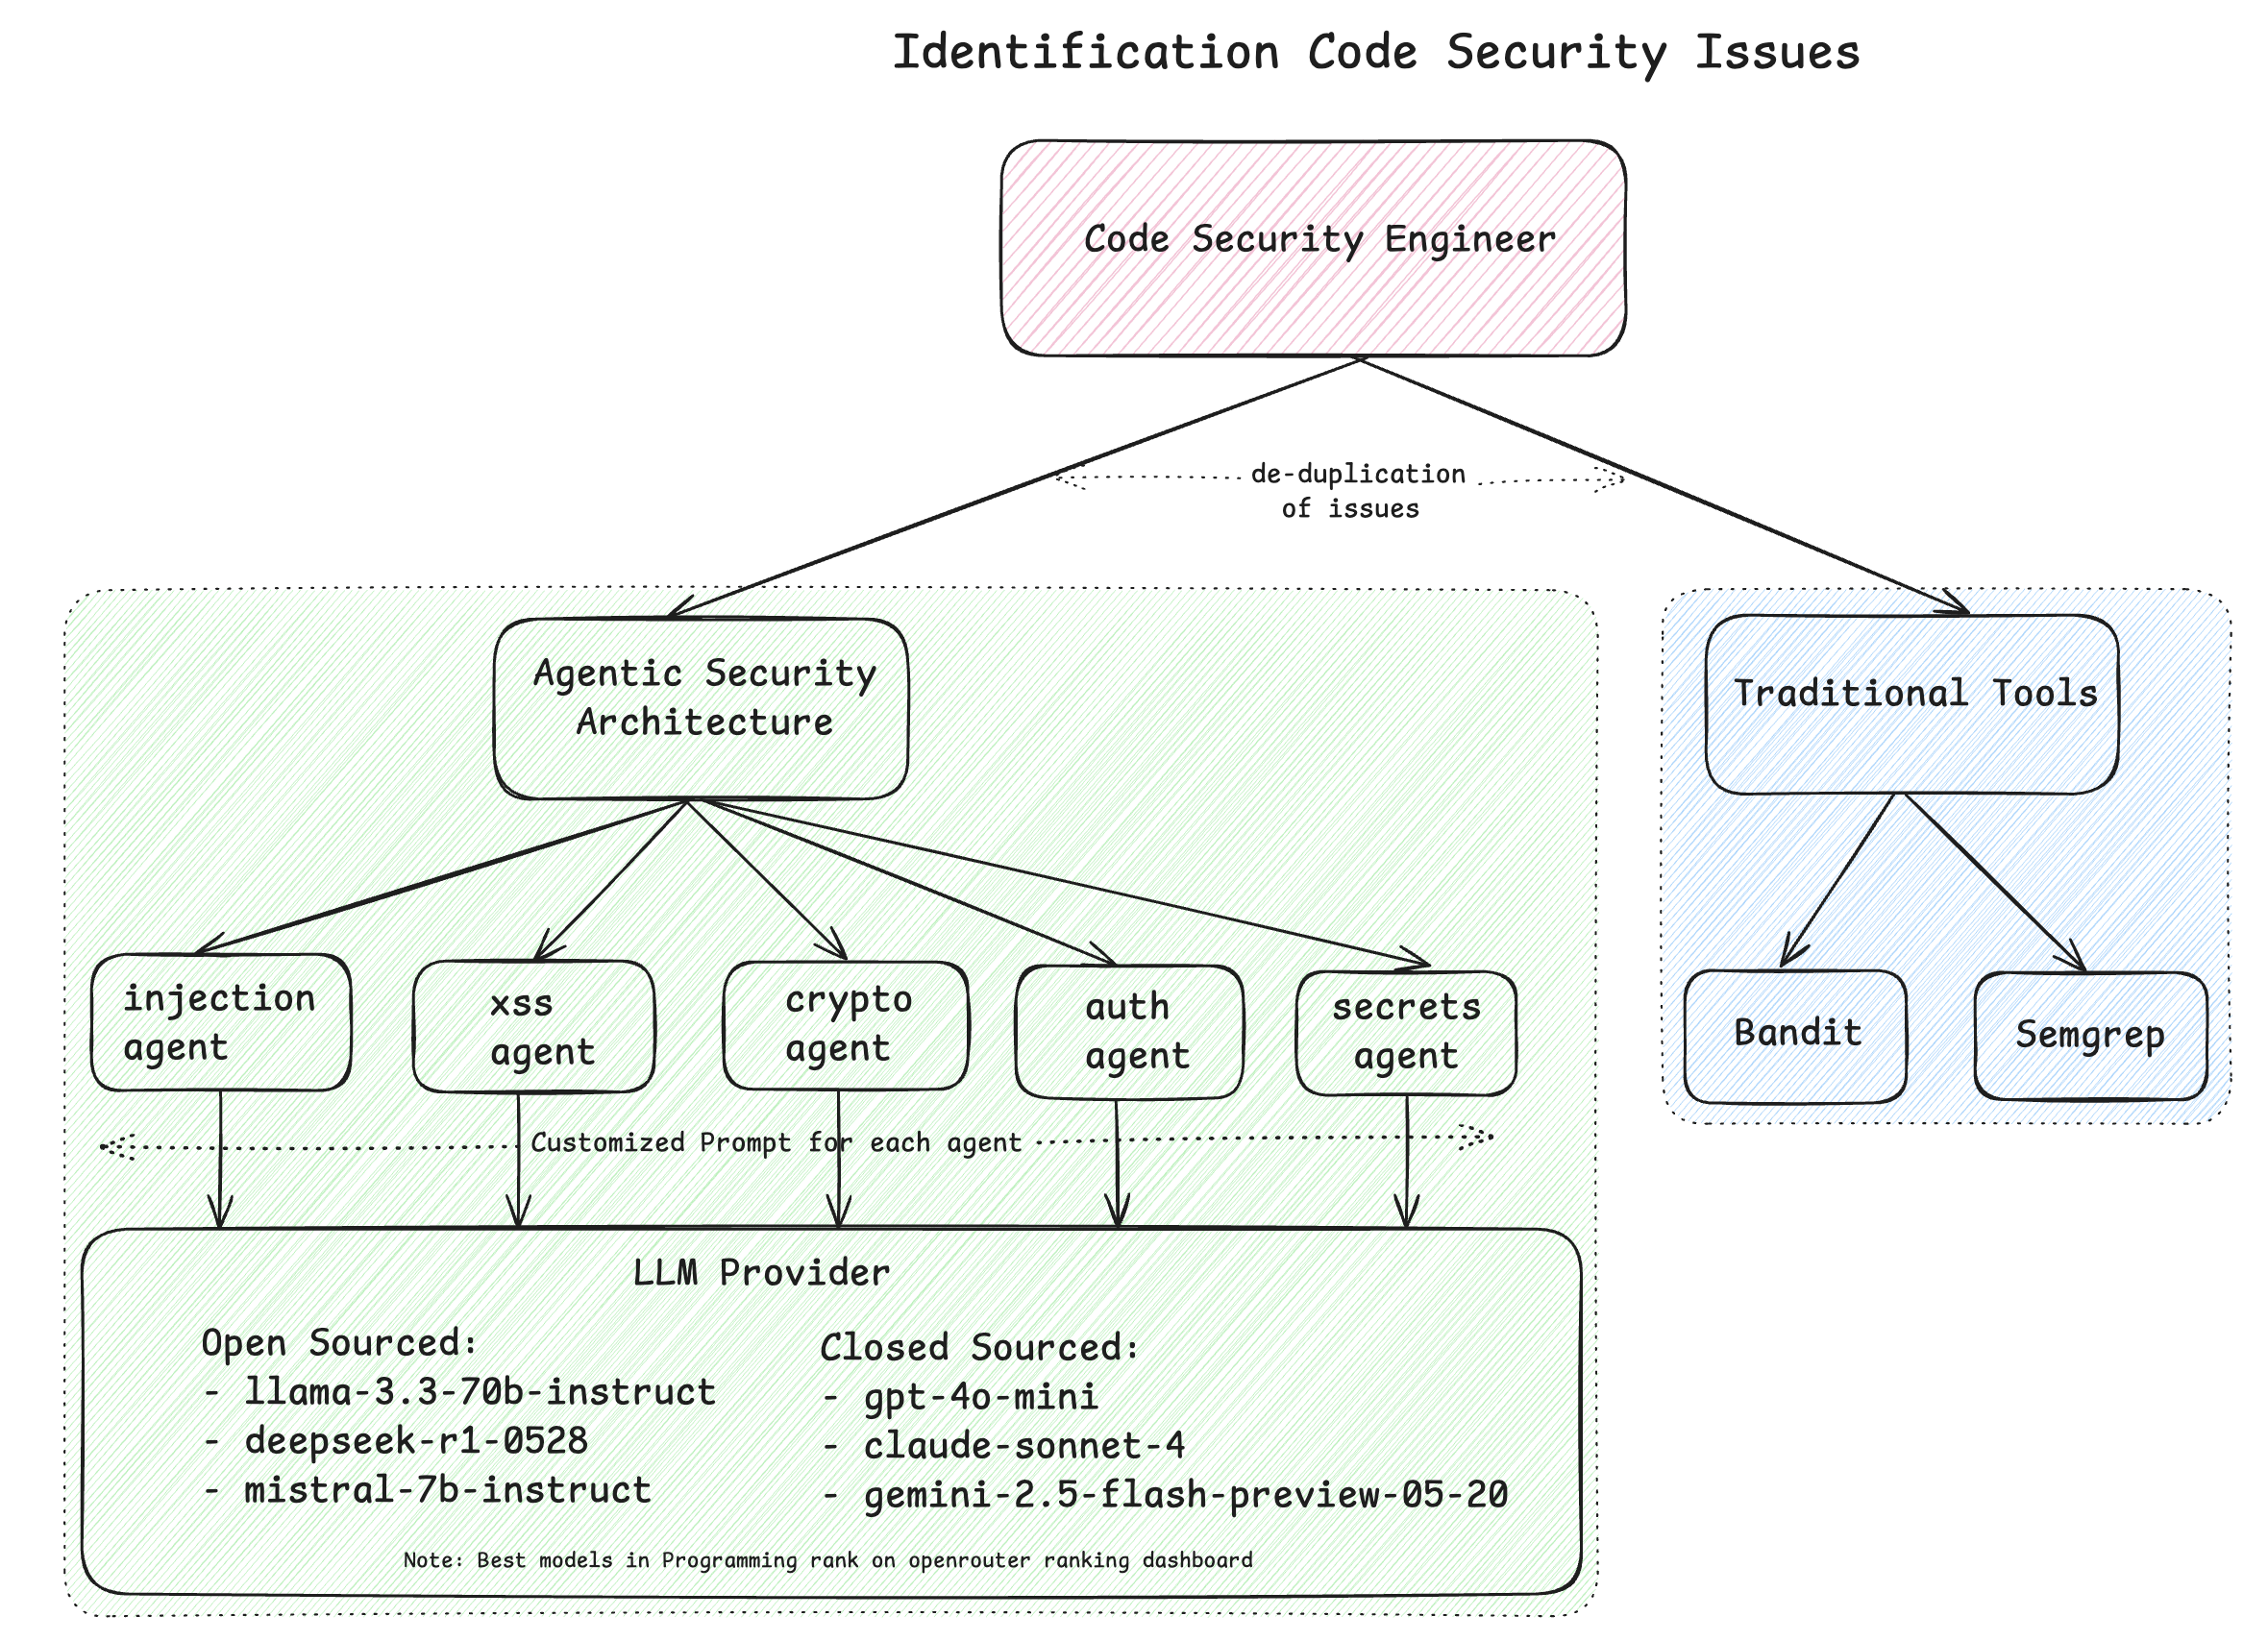

In [ ]:
"""
Advanced Security Engineer Agent for Code Vulnerability Detection
Supports both open-source and closed-source LLMs via OpenRouter API

Features:
- Multi-LLM support (GPT-4, Claude, CodeLlama, etc.)
- Agentic architecture with specialized security agents
- Integration with traditional SAST tools (Bandit, Semgrep)
- Comprehensive vulnerability detection
- Repository-wide security analysis
"""

#### Imports

In [ ]:
import os
import json
import asyncio
import subprocess
import tempfile
import shutil
from pathlib import Path
from typing import Dict, List, Optional, Any, Tuple
from dataclasses import dataclass, asdict
from enum import Enum
import requests
import ast
import re
from datetime import datetime
import hashlib

In [ ]:
# Install required packages
required_packages = [
    "requests", "aiohttp", "gitpython", "bandit", "semgrep",
    "safety", "pip-audit", "asyncio", "pathlib", "sarif-om",
    "rapidfuzz"
]

for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.run(["pip", "install", package], check=True)

Installing gitpython...


In [ ]:
import git
from bandit.core import manager as bandit_manager
from bandit.core import config as bandit_config

#### Mounting drive: Test cases

In [ ]:
""" Mount test cases from Google drive """

!cp -r /content/drive/MyDrive/BlackBoxAI/test_cases /content/

#### Data classes

In [ ]:
@dataclass
class SecurityFinding:
    file_path: str
    line_number: int
    vulnerability_type: str
    severity: str
    title: str
    description: str
    code_snippet: str
    recommendation: str
    confidence: float
    tool_source: str
    cwe_id: Optional[str] = None
    cvss_score: Optional[float] = None

In [ ]:
@dataclass
class SecurityReport:
    timestamp: str
    repository_path: str
    total_files_scanned: int
    findings: List[SecurityFinding]
    summary: Dict[str, int]
    recommendations: List[str]


#### LLM Registry

In [ ]:
class LLMProvider:
    def __init__(self, api_key: str, model_name: str, base_url: str = "https://openrouter.ai/api/v1"):
        self.api_key = api_key
        self.model_name = model_name
        self.base_url = base_url
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }

    def analyze_code(self, code: str, context: str = "") -> Dict[str, Any]:
        """Analyze code for security vulnerabilities using LLM"""

        security_prompt = f"""
          You are an expert security engineer. Analyze the following code for security vulnerabilities, any malicious activity:

          Context: {context}

          Code:
          ```
          {code}
          ```

          Please identify:
          1. Security vulnerabilities (SQL injection, XSS, command injection, etc.)
          2. Insecure coding practices
          3. Potential data exposure risks
          4. Authentication/authorization issues
          5. Input validation problems
          6. Cryptographic weaknesses
          7. Hardcoded secrets or credentials
          8. Suspicious or malicious patterns

          For each issue found, provide:
          - Vulnerability type
          - Severity ("critical","high","medium","low","info")
          - Line number (if applicable)
          - Description
          - Recommendation for fixing
          - CWE ID if applicable

          Respond in JSON format:
          {{
              "vulnerabilities": [
                  {{
                      "type": "vulnerability_type",
                      "severity": "severity_level",
                      "line": line_number,
                      "title": "Brief title",
                      "description": "Detailed description",
                      "recommendation": "How to fix",
                      "cwe_id": "CWE-XXX",
                      "confidence": 0.95
                  }}
              ],
              "overall_risk": "risk_level",
              "summary": "Brief summary of findings"
          }}
        """

        try:
            response = requests.post(
                f"{self.base_url}/chat/completions",
                headers=self.headers,
                json={
                    "model": self.model_name,
                    "messages": [{"role": "user", "content": security_prompt}],
                    "temperature": 0.1,
                    "max_tokens": 2000
                },
                timeout=30
            )

            if response.status_code == 200:
                result = response.json()
                content = result['choices'][0]['message']['content']

                # Extract JSON from response
                try:
                    json_start = content.find('{')
                    json_end = content.rfind('}') + 1
                    json_content = content[json_start:json_end]
                    return json.loads(json_content)
                except (json.JSONDecodeError, ValueError):
                    return {"vulnerabilities": [], "error": "Failed to parse LLM response"}
            else:
                return {"vulnerabilities": [], "error": f"API error: {response.status_code}"}

        except Exception as e:
            return {"vulnerabilities": [], "error": str(e)}

In [ ]:
""" LLMProvider Tester """

# obj = LLMProvider("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", "google/gemini-2.5-flash-preview-05-20") # deepseek/deepseek-chat

# ret = obj.analyze_code("""
# def login(username, password):
#     query = "SELECT * FROM users WHERE username='" + username + "' AND password='" + password + "'"
#     cursor.execute(query)
#     return cursor.fetchone()

# def search_products(category):
#     sql = f"SELECT * FROM products WHERE category = '{category}'"
#     return db.execute(sql)
# """)

# ret

{'vulnerabilities': [{'type': 'SQL Injection',
   'severity': 'Critical',
   'line': 4,
   'title': 'SQL Injection in login function',
   'description': 'The `login` function constructs an SQL query by directly concatenating user-supplied `username` and `password` without proper sanitization or parameterization. This allows an attacker to inject malicious SQL code, bypass authentication, or extract sensitive data from the database.',
   'recommendation': "Use parameterized queries (prepared statements) for all database interactions. Most database libraries provide mechanisms for this (e.g., `cursor.execute('SELECT * FROM users WHERE username=? AND password=?', (username, password))` or `cursor.execute('SELECT * FROM users WHERE username=%s AND password=%s', (username, password))` depending on the database connector). Never concatenate user input directly into SQL queries.",
   'cwe_id': 'CWE-89',
   'confidence': 0.99},
  {'type': 'SQL Injection',
   'severity': 'Critical',
   'line': 

#### Traditional Security check tools

In [ ]:
class TraditionalSASTTools:
    """Integration with traditional SAST tools"""

    @staticmethod
    def run_bandit(file_path: str) -> List[Dict]:
        """Run Bandit security scanner"""
        try:
            # Configure Bandit
            conf = bandit_config.BanditConfig()
            b_mgr = bandit_manager.BanditManager(conf, 'file')
            b_mgr.discover_files([file_path])
            b_mgr.run_tests()

            results = []
            for result in b_mgr.get_issue_list():
                # print(dir(result)) to get all attributes of result
                results.append({
                    'filename': result.fname,
                    'line_number': result.lineno,
                    'test_name': result.test,
                    'issue_severity': result.severity,
                    'issue_confidence': result.confidence,
                    'issue_text': result.text,
                    # 'line_range': result.line_range,
                    'code': result.get_code()
                })
            return results
        except Exception as e:
            print(f"Bandit analysis failed: {e}")
            return []

    @staticmethod
    def run_semgrep(directory: str) -> List[Dict]:
        """Run Semgrep security scanner"""
        try:
            cmd = [
                "semgrep",
                "--config=auto",
                "--json",
                "--quiet",
                directory
            ]
            result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)

            if result.returncode == 0:
                data = json.loads(result.stdout)
                return data.get('results', [])
            else:
                print(f"Semgrep failed: {result.stderr}")
                return []

        except (subprocess.TimeoutExpired, json.JSONDecodeError, Exception) as e:
            print(f"Semgrep analysis failed: {e}")
            return []

In [109]:
""" Traditional Tools tester """

# traditional_tool = TraditionalSASTTools()

# traditional_tool.run_semgrep("/content/repo_folder")

[{'check_id': 'dockerfile.security.missing-user-entrypoint.missing-user-entrypoint',
  'path': '/content/repo_folder/Dockerfile',
  'start': {'line': 13, 'col': 1, 'offset': 166},
  'end': {'line': 13, 'col': 22, 'offset': 187},
  'extra': {'message': "By not specifying a USER, a program in the container may run as 'root'. This is a security hazard. If an attacker can control a process running as root, they may have control over the container. Ensure that the last USER in a Dockerfile is a USER other than 'root'.",
   'fix': 'USER non-root\nENTRYPOINT ["python"]',
   'metadata': {'cwe': ['CWE-269: Improper Privilege Management'],
    'category': 'security',
    'technology': ['dockerfile'],
    'confidence': 'MEDIUM',
    'owasp': ['A04:2021 - Insecure Design'],
    'references': ['https://owasp.org/Top10/A04_2021-Insecure_Design'],
    'subcategory': ['audit'],
    'likelihood': 'LOW',
    'impact': 'MEDIUM',
    'license': 'Semgrep Rules License v1.0. For more details, visit semgrep.

#### Security Agents

In [ ]:
class SecurityAgent:
    """Individual security agent for specific vulnerability types"""

    def __init__(self, agent_type: str, llm_provider: LLMProvider):
        self.agent_type = agent_type
        self.llm = llm_provider
        self.specialization = {
            "injection": ["SQL injection", "Command injection", "LDAP injection"],
            "xss": ["Cross-site scripting", "DOM-based XSS", "Stored XSS"],
            "crypto": ["Weak encryption", "Insecure hashing", "Key management"],
            "auth": ["Authentication bypass", "Authorization flaws", "Session management"],
            "secrets": ["Hardcoded credentials", "API keys", "Sensitive data exposure"]
        }

    def analyze(self, code: str, file_path: str) -> List[SecurityFinding]:
        """Specialized analysis based on agent type"""

        specialized_prompt = f"""
          As a security expert specializing in {self.agent_type} vulnerabilities, analyze this code:

          File: {file_path}
          Focus areas: {', '.join(self.specialization.get(self.agent_type, []))}

          Code:
          {code}

          Look specifically for {self.agent_type}-related security issues and provide detailed analysis.
        """

        result = self.llm.analyze_code(code, specialized_prompt)
        findings = []

        for vuln in result.get('vulnerabilities', []):
            finding = SecurityFinding(
                file_path=file_path,
                line_number=vuln.get('line', 0),
                vulnerability_type=vuln.get('type', 'information_disclosure'),
                severity=vuln.get('severity', 'medium').lower(),
                title=vuln.get('title', ''),
                description=vuln.get('description', ''),
                code_snippet=code[:200] + "..." if len(code) > 200 else code,
                recommendation=vuln.get('recommendation', ''),
                confidence=vuln.get('confidence', 0.5),
                tool_source=f"SecurityAgent-{self.agent_type}",
                cwe_id=vuln.get('cwe_id')
            )
            findings.append(finding)

        return findings


In [ ]:
""" SecurityAgent Tester """

# agent = SecurityAgent("injection" ,obj)
# agent.analyze(
#     """
# def login(username, password):
#     query = "SELECT * FROM users WHERE username='" + username + "' AND password='" + password + "'"
#     cursor.execute(query)
#     return cursor.fetchone()

# def search_products(category):
#     sql = f"SELECT * FROM products WHERE category = '{category}'"
#     return db.execute(sql)
# """, "/content/test_cases/bank.py"
# )

[SecurityFinding(file_path='/content/test_cases/bank.py', line_number=3, vulnerability_type='SQL Injection', severity='critical', title='SQL Injection in login function', description="The `login` function constructs an SQL query by directly concatenating user-supplied `username` and `password` values into the query string. This allows an attacker to inject malicious SQL code, bypass authentication, or access/modify sensitive data. For example, a `username` of `' OR '1'='1` and any `password` could bypass authentication.", code_snippet='\ndef login(username, password):\n    query = "SELECT * FROM users WHERE username=\'" + username + "\' AND password=\'" + password + "\'"\n    cursor.execute(query)\n    return cursor.fetchone()\n\ndef search_p...', recommendation='Use parameterized queries (prepared statements) with placeholders for user input. Most database connectors provide this functionality (e.g., `cursor.execute("SELECT * FROM users WHERE username=? AND password=?", (username, pas

#### Agentic Security Architecture

In [110]:
class AgenticSecurityArchitecture:
    """Multi-agent security analysis system"""

    def __init__(self, openrouter_api_key: str):
        self.api_key = openrouter_api_key
        self.agents = {}
        self.llm_providers = {
            # Closed-source models
            "gpt-4-turbo": LLMProvider(openrouter_api_key, "openai/gpt-4o-mini"),
            "claude-3.5-sonnet": LLMProvider(openrouter_api_key, "anthropic/claude-sonnet-4"),
            "gemini-1.5-pro": LLMProvider(openrouter_api_key, "google/gemini-2.5-flash-preview-05-20"),

            # Open-source models
            "llama-3.3-70b": LLMProvider(openrouter_api_key, "meta-llama/llama-3.3-70b-instruct"),
            "deepseek-r1": LLMProvider(openrouter_api_key, "deepseek/deepseek-r1-0528"), # deepseek/deepseek-chat
            "mistral-7b": LLMProvider(openrouter_api_key, "mistralai/mistral-7b-instruct")
        }

        # Initialize specialized agents
        self._initialize_agents()

    def _initialize_agents(self):
        """Initialize specialized security agents"""
        agent_types = ["injection", "xss", "crypto", "auth", "secrets"]

        for agent_type in agent_types:
            # Use different models for different agents
            model_name = list(self.llm_providers.keys())[
                hash(agent_type) % len(self.llm_providers)
            ]
            self.agents[agent_type] = SecurityAgent(
                agent_type,
                self.llm_providers[model_name]
            )

    def analyze_file(self, file_path: str) -> List[SecurityFinding]:
        """Analyze a single file using multiple agents"""

        if not os.path.exists(file_path):
            return []

        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                code = f.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return []

        if not code.strip():
            return []

        # Run all agents concurrently
        agent_results = []
        for agent_name, agent in self.agents.items():
            agent_results.append(agent.analyze(code, file_path))

        # agent_results = asyncio.gather(*tasks, return_exceptions=True)
        # print(agent_results)

        # Combine results
        all_findings = []
        for result in agent_results:
            if isinstance(result, list):
                all_findings.extend(result)
            elif isinstance(result, Exception):
                print(f"Agent analysis failed: {result}")

        # Add traditional SAST results
        traditional_findings = self._run_traditional_tools(file_path)
        all_findings.extend(traditional_findings)

        return all_findings

    def _run_traditional_tools(self, file_path: str) -> List[SecurityFinding]:
        """Run traditional SAST tools and convert results"""
        findings = []

        # Bandit for Python files
        if file_path.endswith('.py'):
            bandit_results = TraditionalSASTTools.run_bandit(file_path)
            for result in bandit_results:
                finding = SecurityFinding(
                    file_path=result['filename'],
                    line_number=result['line_number'],
                    vulnerability_type="Default",
                    severity=result['issue_severity'].lower(),
                    title=result['test_name'],
                    description=result['issue_text'],
                    code_snippet=result.get('code', ''),
                    recommendation="Review and fix the identified security issue",
                    confidence=result.get('issue_confidence', ''),
                    tool_source="Bandit"
                )
                findings.append(finding)

        return findings

    def analyze_repository(self, repo_path: str) -> SecurityReport:
        """Analyze entire repository"""

        print(f"Starting security analysis of repository: {repo_path}")

        # Discover files to analyze
        code_files = self._discover_code_files(repo_path)
        print(f"Found {len(code_files)} code files to analyze")

        # Run Semgrep on entire repository
        semgrep_results = TraditionalSASTTools.run_semgrep(repo_path)

        # Analyze files concurrently (in batches to avoid API limits)
        batch_size = min(len(code_files), 5)
        all_findings = []

        for i in range(0, len(code_files), batch_size):
            batch = code_files[i:i + batch_size]
            batch_results = [self.analyze_file(file_path) for file_path in batch]
            # batch_results = asyncio.gather(*tasks, return_exceptions=True)

            for result in batch_results:
                if isinstance(result, list):
                    all_findings.extend(result)

            # Rate limiting
            # await asyncio.sleep(1)

        # Add Semgrep findings
        semgrep_findings = self._convert_semgrep_results(semgrep_results)
        all_findings.extend(semgrep_findings)

        # Generate summary
        summary = self._generate_summary(all_findings)
        recommendations = self._generate_recommendations(all_findings)

        report = SecurityReport(
            timestamp=datetime.now().isoformat(),
            repository_path=repo_path,
            total_files_scanned=len(code_files),
            findings=all_findings,
            summary=summary,
            recommendations=recommendations
        )

        return report

    def _discover_code_files(self, directory: str) -> List[str]:
        """Discover code files in repository"""

        code_extensions = {
            '.py', '.js', '.ts', '.java', '.c', '.cpp', '.cs', '.php',
            '.rb', '.go', '.rs', '.scala', '.kt', '.swift', '.m', '.h',
            '.jsx', '.tsx', '.vue', '.sql', '.yaml', '.yml', '.json',
            '.html', '.txt', '.md', 'Dockerfile', '.db'
        }

        code_files = []
        exclude_dirs = {'.git', 'node_modules', '__pycache__', '.pytest_cache',
                       'venv', 'env', 'build', 'dist', '.vscode', '.idea'}

        for root, dirs, files in os.walk(directory):
            # Skip excluded directories
            dirs[:] = [d for d in dirs if d not in exclude_dirs]

            for file in files:
                if any(file.endswith(ext) for ext in code_extensions):
                    file_path = os.path.join(root, file)
                    if os.path.getsize(file_path) < 1024 * 1024:  # Skip files > 1MB
                        code_files.append(file_path)

        if len(code_files) == 0 and any(directory.endswith(ext) for ext in code_extensions):
            code_files.append(directory)

        return code_files

    def _convert_semgrep_results(self, semgrep_results: List[Dict]) -> List[SecurityFinding]:
        """Convert Semgrep results to SecurityFinding objects"""
        findings = []

        for result in semgrep_results:
            finding = SecurityFinding(
                file_path=result.get('path', ''),
                line_number=result.get('start', {}).get('line', 0),
                vulnerability_type="Default",
                severity=result.get('extra', {}).get('severity', 'medium').lower(),
                title=result.get('check_id', ''),
                description=result.get('extra', {}).get('message', ''),
                code_snippet=result.get('extra', {}).get('lines', ''),
                recommendation="Review and address the security issue identified by Semgrep",
                confidence=result.get('extra', {}).get('confidence', ''),
                cwe_id=result.get('extra', {}).get('metadata',{}).get('cwe', []),
                tool_source="Semgrep"
            )
            findings.append(finding)

        return findings

    def _generate_summary(self, findings: List[SecurityFinding]) -> Dict[str, int]:
        """Generate summary statistics"""
        summary = {
            'total_findings': len(findings),
            'critical': 0,
            'high': 0,
            'medium': 0,
            'low': 0,
            'info': 0
        }

        for finding in findings:
            summary[finding.severity] = summary.get(finding.severity, 0) + 1

        return summary

    def _generate_recommendations(self, findings: List[SecurityFinding]) -> List[str]:
        """Generate high-level recommendations"""
        recommendations = []

        severity_counts = {}
        vuln_types = {}

        for finding in findings:
            severity_counts[finding.severity] = severity_counts.get(finding.severity, 0) + 1
            vuln_types[finding.vulnerability_type] = vuln_types.get(finding.vulnerability_type, 0) + 1

        if severity_counts.get('critical', 0) > 0:
            recommendations.append("CRITICAL: Address critical vulnerabilities immediately")

        if severity_counts.get('high', 0) > 5:
            recommendations.append("HIGH PRIORITY: Multiple high-severity issues found - implement security review process")

        if 'sql_injection' in vuln_types:
            recommendations.append("Implement parameterized queries and input validation")

        if 'hardcoded_secrets' in vuln_types:
            recommendations.append("Move secrets to environment variables or secure vault")

        if len(findings) > 20:
            recommendations.append("Consider implementing automated security testing in CI/CD pipeline")

        recommendations.append("Regular security audits and dependency updates recommended")

        return recommendations

    def save_report(self, report: SecurityReport, output_file: str):
        """Save security report to file"""

        # Convert to serializable format
        report_dict = asdict(report)

        # Convert enums to strings
        for finding in report_dict['findings']:
            finding['vulnerability_type'] = finding['vulnerability_type']
            finding['severity'] = finding['severity']

        with open(output_file, 'w') as f:
            json.dump(report_dict, f, indent=2, default=str)

        print(f"Security report saved to: {output_file}")

In [ ]:
""" AgenticSecurityArchitecture Tester """

# obj = AgenticSecurityArchitecture("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")
# # ret = obj.analyze_file("/content/demo/bank.py")

# with open("/content/test_cases/bank.py", 'r', encoding='utf-8', errors='ignore') as f:
#   code = f.read()

# # obj.agents["injection"].analyze(code, "/content/test_cases/bank.py")
# obj._discover_code_files("https://github.com/signalapp/Signal-Server")


#### De-duplication of issues

In [114]:
from sentence_transformers import SentenceTransformer
from rapidfuzz import fuzz
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def remove_duplicate_findings_embeddings_fuzzy(critical_and_high):
    """Remove duplicates using embedding similarity of title and fuzzy work matching"""
    # Initialize embedding model
    embed_model = SentenceTransformer("all-MiniLM-L6-v2")

    kept_embeddings = []
    unique_critical = []
    for f in critical_and_high:
        title = f.title.strip()
        # Compute title embedding
        emb = embed_model.encode(title, convert_to_numpy=True)
        skip = False
        for kept_emb, kept_f in zip(kept_embeddings, unique_critical):
            # Cosine similarity
            sim = cosine_similarity(
                emb.reshape(1, -1),
                kept_emb.reshape(1, -1)
            )[0][0]
            # Fuzzy token-sort ratio
            fuzzy_score = fuzz.token_sort_ratio(title, kept_f.title)
            if sim > 0.7 or fuzzy_score > 90: # Tune threshold based on desired Recall
                skip = True
                break
        if not skip:
            kept_embeddings.append(emb)
            unique_critical.append(f)

    return unique_critical

def remove_duplicate_findings_hash(findings):
    """Remove duplicates using hash of normalized title and description"""
    seen_hashes = set()
    unique_findings = []

    for finding in findings:
        # Normalize and create hash
        normalized_file_path = finding.file_path.strip().lower().replace(' ', '')

        # Create hash of combined content
        content_hash = hashlib.md5(
            (normalized_file_path + ":" + str(finding.line_number)).encode('utf-8')
        ).hexdigest()

        if content_hash not in seen_hashes:
            seen_hashes.add(content_hash)
            unique_findings.append(finding)

    return unique_findings

def download_github_repo(github_url: str) -> str:
        """Download GitHub repository to temporary directory"""
        repo_dir = os.getcwd() + "/repo_folder"
        # Check if the directory exists
        if os.path.exists(repo_dir):
            # If it exists, remove it
            shutil.rmtree(repo_dir)
            print(f"Removed existing directory: {repo_dir}")
        subprocess.run(['git', 'clone', github_url, repo_dir], check=True)
        return repo_dir

#### Main function

In [115]:
# Example usage and main function
def main():
    """Main function demonstrating the security agent"""

    # Replace with your OpenRouter API key
    OPENROUTER_API_KEY = "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"

    if OPENROUTER_API_KEY == "":
        print("Please set your OpenRouter API key in the OPENROUTER_API_KEY variable")
        return

    # Initialize the agentic security system
    security_system = AgenticSecurityArchitecture(OPENROUTER_API_KEY)

    # Example: Analyze a repository
    repo_path = input("Enter repository/file path to analyze (or '.' for current directory): ").strip()
    if not repo_path:
        repo_path = "."

    # If it's a GitHub URL, download it first
    if 'github.com' in repo_path:
        repo_path = download_github_repo(repo_path)

    print("Starting comprehensive security analysis...")
    print("This may take several minutes depending on repository size...")

    try:
        # Run the analysis
        report = security_system.analyze_repository(repo_path)

        # Display results
        print("\n" + "="*60)
        print("SECURITY ANALYSIS REPORT")
        print("="*60)
        print(f"Repository: {report.repository_path}")
        print(f"Timestamp: {report.timestamp}")
        print(f"Files Scanned: {report.total_files_scanned}")
        print(f"Total Findings: {report.summary['total_findings']}")
        print("\nSeverity Breakdown:")
        print(f"  Critical: {report.summary['critical']}")
        print(f"  High: {report.summary['high']}")
        print(f"  Medium: {report.summary['medium']}")
        print(f"  Low: {report.summary['low']}")
        print(f"  Info: {report.summary['info']}")

        # Show top findings
        if report.findings:
            critical_and_high = [f for f in report.findings
                               if f.severity in ["critical", "high"]]
            critical_and_high = remove_duplicate_findings_hash(critical_and_high)
            print("\nTOP SECURITY FINDINGS:")

            # Sort based on severity
            # Define a weight for severity level
            severity_weight = {
                "critical": 0,
                "high": 1
            }

            # in-place sorting
            critical_and_high.sort(key=lambda f: severity_weight.get(f.severity, 99))

            for i, finding in enumerate(critical_and_high[:10], 1):  # Show top 10
                print(f"\n{i}. {finding.title}")
                print(f"   File: {finding.file_path}:{finding.line_number}")
                print(f"   Severity: {finding.severity.upper()}")
                print(f"   Tool: {finding.tool_source}")
                print(f"   Description: {finding.description[:100]}...")

        # Show recommendations
        if report.recommendations:
            print("\nRECOMMENDATIONS:")
            for i, rec in enumerate(report.recommendations, 1):
                print(f"{i}. {rec}")

        # Save detailed report
        output_file = f"security_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        security_system.save_report(report, output_file)

        print(f"\nAnalysis complete! Detailed report saved to: {output_file}")

    except Exception as e:
        print(f"Analysis failed: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
if __name__ == "__main__":
    # loop = asyncio.get_event_loop()
    # loop.run_until_complete(main())
    # await main()
    main()

Enter repository/file path to analyze (or '.' for current directory): https://github.com/we45/Vulnerable-Flask-App.git
Removed existing directory: /content/repo_folder
Starting comprehensive security analysis...
This may take several minutes depending on repository size...
Starting security analysis of repository: /content/repo_folder
Found 16 code files to analyze
